In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [2]:
#http://berkeleyearth.org/air-pollution-overview/

from pandas import read_csv
from datetime import datetime

def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')
	
df = pd.read_csv('Thailand.csv', usecols=[0,1,2,3,4], engine='python', 
				parse_dates = [['Year', 'Month', 'Day', 'Hour']], 
				index_col=0, date_parser=parse)
df.index.name = 'date'
df 

,PM2.5
date,
2016-03-03 08:00:00,53.99
2016-03-03 09:00:00,53.95
2016-03-03 10:00:00,54.10
2016-03-03 11:00:00,53.93
2016-03-03 12:00:00,41.23
...,...
2022-03-13 17:00:00,56.30
2022-03-13 18:00:00,53.34
2022-03-13 19:00:00,51.25


In [3]:
df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
PM2.5,46904.0,24.04,13.63,4.02,13.14,19.49,33.05,131.54


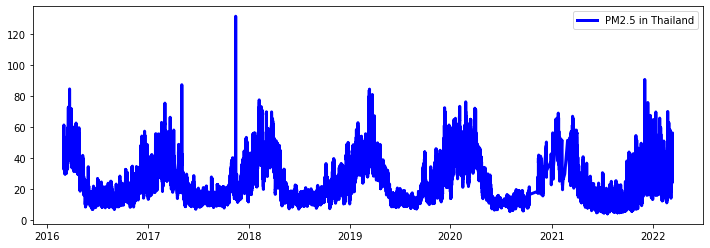

In [4]:

plt.figure(figsize=(12, 4))
plt.plot(df, 'b', lw=3.0, label='PM2.5 in Thailand')
plt.legend()
plt.show()

In [267]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 46904 entries, 2016-03-03 08:00:00 to 2022-03-13 21:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PM2.5   46904 non-null  float64
dtypes: float64(1)
memory usage: 732.9 KB


(46904, 1)

##### การแบ่งข้อมูลใช้ในการ train และ test

In [268]:
n_train = int(df.shape[0] * 0.80)
n_train

37523

##### การแปลงข้อมูลให้เป็น Normalize คือแปลงข้อมูลให้เป็นเลข 0-1

In [269]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()
data_sc = sc.fit_transform(df.values)
data_sc[:5]

array([[0.3918601 ],
       [0.39154642],
       [0.39272271],
       [0.39138959],
       [0.29179737]])

##### สร้างฟังก์ชันเพื่อเตรียมข้อมูลให้เป็น matrix ใช้ step = 2

In [270]:
def convertToMatrix(data, step=2):
    X, Y, = [], []
    for i in range(len(data)-step):
        d = i + step
        X.append(data[i:d,])
        Y.append(data[d,])
    return np.array(X), np.array(Y)

##### การแบ่งข้อมูลเพื่อใช้ในการ train และ test 

In [271]:
train, test = data_sc[0:n_train], data_sc[n_train:]
train.shape, test.shape

((37523, 1), (9381, 1))

In [272]:
step = 2

X_train, y_train = convertToMatrix(train, step)
X_test, y_test = convertToMatrix(test, step)

print('Train Test (after conversion):', X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

Train Test (after conversion): (37521, 2, 1) (9379, 2, 1)
(37521, 1) (9379, 1)


##### การสร้างโมเดล AI

In [273]:
model = Sequential()
model.add(LSTM(units=32, input_shape=(step, 1), activation='relu'))
model.add(Dense(1))

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 32)                4352      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


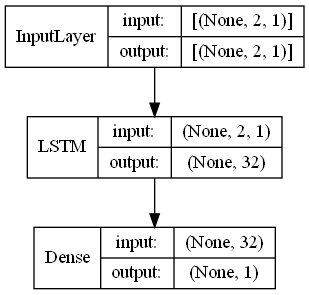

In [274]:
from tensorflow.keras.utils import plot_model
plot_model(model, 'my_lstm.png', show_shapes=True, show_layer_names=False)

In [275]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [276]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
1173/1173 [==============================] - 3s 2ms/step - loss: 0.0020
Epoch 2/10
1173/1173 [==============================] - 2s 2ms/step - loss: 4.7947e-04
Epoch 3/10
1173/1173 [==============================] - 2s 2ms/step - loss: 4.0957e-04
Epoch 4/10
1173/1173 [==============================] - 2s 2ms/step - loss: 3.8235e-04
Epoch 5/10
1173/1173 [==============================] - 2s 2ms/step - loss: 3.7794e-04
Epoch 6/10
1173/1173 [==============================] - 3s 3ms/step - loss: 3.7753e-04
Epoch 7/10
1173/1173 [==============================] - 3s 3ms/step - loss: 3.7708e-04
Epoch 8/10
1173/1173 [==============================] - 3s 3ms/step - loss: 3.7520e-04
Epoch 9/10
1173/1173 [==============================] - 3s 3ms/step - loss: 3.7553e-04
Epoch 10/10
1173/1173 [==============================] - 3s 2ms/step - loss: 3.7496e-04


In [287]:
score = model.evaluate(X_test, y_test, verbose=1)
print(score)

294/294 [==============================] - 0s 1ms/step - loss: 8.0101e-04
0.0008010061574168503


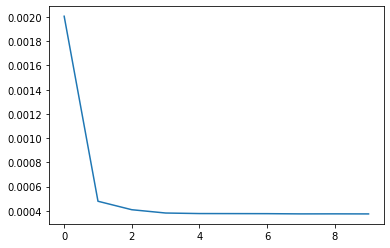

In [288]:
plt.plot(history.history['loss'], label='Train loss')
plt.legend
plt.show()

In [289]:
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)
trainPredict

array([[0.3845892 ],
       [0.3860368 ],
       [0.38423175],
       ...,
       [0.07994591],
       [0.09130415],
       [0.09138776]], dtype=float32)

In [290]:
testPredict = model.predict(X_test)
test = np.argmax(testPredict, axis=1)

test2 = np.argmax(y_test, axis=1)

In [291]:
dm = pd.DataFrame({'ข้อมูลจริง': test2, 'ข้อมูลพยากรณ์': test})
dm

,ข้อมูลจริง,ข้อมูลพยากรณ์
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
9374,0,0
9375,0,0
9376,0,0
9377,0,0


In [292]:
from sklearn.metrics import mean_squared_error, r2_score

trainPredict_inv = sc.inverse_transform(trainPredict)
testPredict_inv = sc.inverse_transform(testPredict)
y_train_inv = sc.inverse_transform(y_train)
y_test_inv = sc.inverse_transform(y_test)

r2_train = r2_score(y_train_inv, trainPredict_inv)
r2_test = r2_score(y_test_inv, testPredict_inv)

rmse_train = np.sqrt(mean_squared_error(y_train_inv, trainPredict_inv))
rmse_test = np.sqrt(mean_squared_error(y_test_inv, testPredict_inv))

print('R2_Train: {:.3f}'.format(r2_train))
print('R2_Test: {:.3f}'.format(r2_test))

print('RMSE Train: {:.3f}'.format(rmse_train))
print('RMSE Test: {:.3f}'.format(rmse_test))


R2_Train: 0.968
R2_Test: 0.924
RMSE Train: 2.445
RMSE Test: 3.609


In [294]:
prefix = np.empty(step).reshape(-1, 1)
prefix.fill(np.nan)

trainPredict_inv = np.concatenate((prefix, trainPredict_inv), axis=0)
testPredict_inv = np.concatenate((prefix, testPredict_inv), axis=0)

predict_inv = np.concatenate((trainPredict_inv, testPredict_inv), axis=0)


In [295]:
predict_inv

array([[        nan],
       [        nan],
       [        nan],
       ...,
       [51.87073135],
       [50.01901245],
       [47.27271271]])

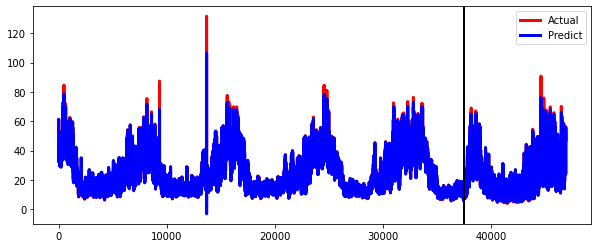

In [307]:
plt.figure(figsize=(10, 4))
plt.plot(df.values, 'r', lw=3.0, label='Actual')
plt.plot(predict_inv, 'b', lw=3.0, label='Predict')
plt.axvline(n_train-step-1, c='black', lw=2.0)
plt.legend()
plt.show()

##### นำส่วนท้ายมาเป็น input มาพยากรณ์จำนวนผู้ป่วยโควิด19 ในวันถัดไป 

In [297]:
X_input = X_train[-step]

pred = model.predict(X_input)
pred_inv = sc.inverse_transform(pred)

#มลพิษ ประเทศไทย ค่า PM 2.5 ไม่ควรเกิน 50 ไมโครกรัม ต่อลูกบาศก์เมตรใน 24 ชั่วโมง
print('พยากรณ์ PM2.5 ระยะเวลา 1 วัน (24 ชม.) =', pred_inv[-1][-1].round(0),'ไมโครกรัมต่อลูกบาศก์เมตร (มคก./ลบ.ม. หรือ µg./m.)')

พยากรณ์ PM2.5 ระยะเวลา 1 วัน (24 ชม.) = 21.0 ไมโครกรัมต่อลูกบาศก์เมตร (มคก./ลบ.ม. หรือ µg./m.)
